In [1]:
import poloniex

In [2]:
import time

# poloniex APIの準備
polo = poloniex.Poloniex()

# 5分間隔（サンプリング間隔300秒）で100日分読み込む
chart_data = polo.returnChartData('BTC_ETH', period=300, start=time.time()-polo.DAY*100, end=time.time())

In [3]:
# pandasのインポート
import pandas as pd

# pandasにデータの取り込み
df = pd.DataFrame(chart_data)

In [4]:
# 短期線：窓幅1日（5分×12×24）
#data_s = pd.rolling_mean(df['close'], 12 * 24) 
data_s = df['close'].rolling(12 * 24).mean()

# 長期線：窓幅5日（5分×12×24×5）
#data_l = pd.rolling_mean(df['close'], 12 * 24 * 5)
data_l = df['close'].rolling(12 * 24 * 5).mean()

In [5]:
# matplotlibの読み込み
import matplotlib.pyplot as plt
# 描画を綺麗に表示する
from matplotlib.pylab import rcParams
import seaborn as sns
rcParams['figure.figsize'] = 15, 6

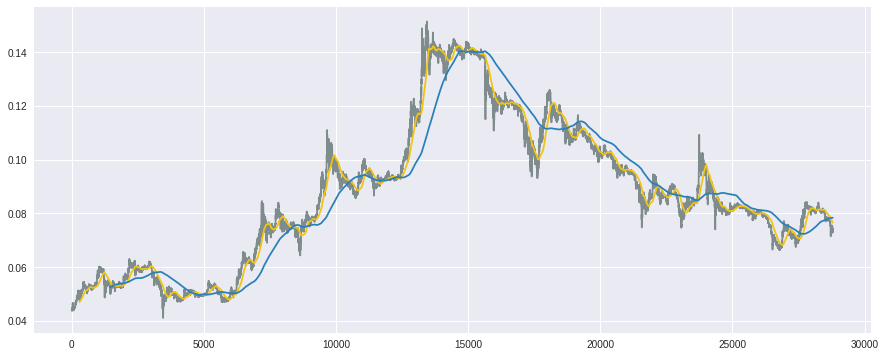

In [6]:
# 短期線と長期線もプロット
plt.plot(df['close'], color='#7f8c8d')
plt.plot(data_s, color='#f1c40f')  # 短期線
plt.plot(data_l, color='#2980b9')  # 長期線
plt.show()

ここからmxnetを使っていく

In [7]:
# mxnetの読み込み
import mxnet as mx
# GPUがないのでCPUを使うようセット
gpu_device = mx.cpu()

/opt/conda/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-08-05 09:54:28.933322. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [8]:
# numpyの読み込み
import numpy as np

# API経由では文字列（String型）として受け取るため、float型に変換しておく
data = df['close'].astype(np.float32)

# データを入力変数xと出力変数tに切り分け
x, t = [], []
N = len(data)
M = 30 # 入力変数の数：直近30サンプルを使用
for n in range(M, N):
    # 入力変数と出力変数の切り分け
    _x = data[n-M: n] # 入力変数
    _t = data[n] # 出力変数
    # 計算用のリスト(x, t)に追加していく
    x.append(_x)
    t.append(_t)

/opt/conda/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-08-05 09:54:31.795738. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [9]:
# mxnetのNDArrayの形式に変換する
x = mx.nd.array(x)
# t = mx.nd.array(t).reshape((len(t), 1))
t = mx.nd.array(t)

/opt/conda/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-08-05 09:54:55.565442. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [10]:
# 70%を訓練用、30%を検証用
N_train = int(N * 0.7)
x_train, x_test = x[:N_train], x[N_train:]
t_train, t_test = t[:N_train], t[N_train:]

/opt/conda/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-08-05 09:55:07.545364. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [11]:
train = list(zip(x_train, t_train))
test  = list(zip(x_test,  t_test))

/opt/conda/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-08-05 09:55:09.085573. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [12]:
# 再現性確保
mx.random.seed(1)

/opt/conda/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-08-05 09:55:13.606003. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [14]:
from mxnet import gluon

net = gluon.nn.Sequential()
with net.name_scope():
#    net.add(gluon.rnn.LSTM(30, dropout=0.05))
    net.add(gluon.nn.Dense(30, activation='relu'))
    net.add(gluon.nn.Dense(1, in_units=30))

net.collect_params().initialize(ctx=mx.cpu())

/opt/conda/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-08-05 10:02:09.955842. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [15]:
optimizer = gluon.Trainer(net.collect_params(), 'Adam', {})

/opt/conda/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-08-05 10:02:15.205622. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [16]:
metric = mx.metric.Accuracy()
loss = gluon.loss.SoftmaxCrossEntropyLoss()

/opt/conda/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-08-05 10:02:16.825598. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [23]:
epochs = 30
for epoch in range(epochs):
    # reset data iterator and metric at begining of epoch.
    metric.reset()
#    data_iter = mx.io.NDArrayIter(data=x_train, label=t_train, batch_size=30)
#    for batch in data_iter:
#        with mx.autograd.record():
#            output = net(mx.nd.array(batch.data))
#            L = loss(output, batch.label)
#            L.backward()
#        optimizer.step(batch.data.shape[0])
#        metric.update([batch.label], [output])
    for data, label in train:
        with mx.autograd.record():
            output = net(mx.nd.array(data))
            for i in range(output.size):
                L = loss(output[i], label)
                L.backward()
                metric.update([label], [output[i]])
        optimizer.step(data.shape[0])
        
    name, acc = metric.get()
    print('[Epoch %d] Training: %s=%f'%(epoch, name, acc))

    metric.reset()
#    test_iter = mx.io.NDArrayIter(data=x_test, label=t_test, batch_size=30)
    for data, label in test:
        output = net(mx.nd.array(data))
        for i in range(output.size):
            metric.update([label], [output[i]])
    
    name, val_acc = metric.get()
    print('[Epoch %d] Validation: %s=%f'%(epoch, name, val_acc))

[Epoch 0] Training: accuracy=1.000000
[Epoch 0] Validation: accuracy=1.000000
[Epoch 1] Training: accuracy=1.000000
[Epoch 1] Validation: accuracy=1.000000
[Epoch 2] Training: accuracy=1.000000
[Epoch 2] Validation: accuracy=1.000000
[Epoch 3] Training: accuracy=1.000000
[Epoch 3] Validation: accuracy=1.000000
[Epoch 4] Training: accuracy=1.000000
[Epoch 4] Validation: accuracy=1.000000
[Epoch 5] Training: accuracy=1.000000
[Epoch 5] Validation: accuracy=1.000000
[Epoch 6] Training: accuracy=1.000000
[Epoch 6] Validation: accuracy=1.000000
[Epoch 7] Training: accuracy=1.000000
[Epoch 7] Validation: accuracy=1.000000
[Epoch 8] Training: accuracy=1.000000
[Epoch 8] Validation: accuracy=1.000000
[Epoch 9] Training: accuracy=1.000000
[Epoch 9] Validation: accuracy=1.000000
[Epoch 10] Training: accuracy=1.000000
[Epoch 10] Validation: accuracy=1.000000
[Epoch 11] Training: accuracy=1.000000
[Epoch 11] Validation: accuracy=1.000000


KeyboardInterrupt: 

/opt/conda/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-08-05 12:20:03.479261. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [24]:
from mxnet import gluon

class Net(gluon.HybridBlock):
    def __init__(self, n_units, n_output, **kwargs):
        super(Net, self).__init__(**kwargs)
        with self.name_scope():
            self.l1 = gluon.rnn.LSTM(n_units, dropout=0.05)
            self.l2 = Dense(n_output)

    def hybrid_forward(self, F, x):
        # F is a function space that depends on the type of x
        # If x's type is NDArray, then F will be mxnet.nd
        # If x's type is Symbol, then F will be mxnet.sym
        print('type(x): {}, F: {}'.format(
                type(x).__name__, F.__name__))
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return h2

/opt/conda/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-08-06 02:02:46.202951. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [16]:
# モデルの宣言
net = Net(30, 1)
net.collect_params().initialize()

ValueError: Children of HybridBlock must also be HybridBlock, but LSTM(30, TNC, dropout=0.05) has type <class 'mxnet.gluon.rnn.rnn_layer.LSTM'>. If you are using Sequential, please try HybridSequential instead

/opt/conda/lib/python3.5/json/encoder.py:198: DeprecationWarning: Interpreting naive datetime as local 2017-08-04 06:28:04.107745. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)
